In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.states import Statevector, partial_trace
from qiskit.quantum_info import state_fidelity
from qiskit.visualization import plot_state_qsphere, plot_state_city
from qiskit.visualization import plot_histogram
from qiskit import Aer, execute
from qiskit.circuit.add_control import add_control
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [29]:
Stabilizers = {
    "K1": {"X": [0,1,2,3,7], "Y": [], "Z": []},
    "K2": {"X": [1,2,4,5,8], "Y": [], "Z": []},
    "K3": {"X": [2,3,5,6,9], "Y": [], "Z": []},
    "K4": {"X": [], "Y": [], "Z": [0,1,2,3]},
    "K5": {"X": [], "Y": [], "Z": [1,2,4,5]},
    "K6": {"X": [], "Y": [], "Z": [2,3,5,6]},
    "K7": {"X": [], "Y": [], "Z": [2,5,7]},
    "K8": {"X": [], "Y": [], "Z": [1,2,9]},
    "K9": {"X": [], "Y": [], "Z": [2,3,8]}
}

In [3]:
# CORRECTION
def correction_z(circuit, creg):

    with circuit.if_test((creg[0], 0)) as else_:
        with circuit.if_test((creg[1], 0)):
            with circuit.if_test((creg[2], 1)):
                print("Warning: error in 6 or 9 qubit (uncorrectable)!")
        with circuit.if_test((creg[1], 1)):
            with circuit.if_test((creg[2], 0)):
                print("Warning: error in 4 or 8 qubit (uncorrectable)!")
            with circuit.if_test((creg[2], 1)):
                circuit.z(5)
    with else_:
        with circuit.if_test((creg[1], 0)):
            with circuit.if_test((creg[2], 0)):
                print("Warning: error in 0 or 7 qubit (uncorrectable)!")
            with circuit.if_test((creg[2], 1)):
                circuit.z(3)
        with circuit.if_test((creg[1], 1)):
            with circuit.if_test((creg[2], 0)):
                circuit.z(1)
            with circuit.if_test((creg[2], 1)):
                circuit.z(2)

    return circuit

In [4]:
# creating STABILIZER
@staticmethod
def stabilizer(qcirc, stblzr_name, ctrl_index):
    
    X = Stabilizers[stblzr_name]["X"]
    Y = Stabilizers[stblzr_name]["Y"]
    Z = Stabilizers[stblzr_name]["Z"]
    if len(X) != 0:
        qcirc.cx(ctrl_index, X)
    if len(Y) != 0:
        qcirc.cy(ctrl_index, Y)
    if len(Z) != 0:
        qcirc.cz(ctrl_index, Z)
    qcirc.barrier() 

    return qcirc

In [5]:
# state PREPARATION
def initialize_qubit(qc1, cl_p, num_qubits, num_anclq):

    qc1.h(range(num_qubits, num_qubits + num_anclq))
    for i in range(num_anclq):
        stabilizer(qc1, f'K{1+i}', num_qubits + i)      # X-stabilizers
    qc1.h(range(num_qubits, num_qubits + num_anclq))
    qc1.measure([10, 11, 12], [10, 11, 12])     # Measurement M{1-3}
    correction_z(qc1, cl_p)     # Correction_Z

    return qc1

In [26]:
num_qubits = 10
phys_qubits = QuantumRegister(num_qubits, 'q')
num_anclq = 3
prepare_q = QuantumRegister(num_anclq, 'p')
ancila_z = QuantumRegister(num_anclq, 'a_z')
# ancila_x = QuantumRegister(num_anclq, 'a_x')
cl_data = ClassicalRegister(num_qubits, 'c_data')
cl_p = ClassicalRegister(num_anclq, 'c_p')
cl_z = ClassicalRegister(num_anclq, 'c_z')
# cl_x = ClassicalRegister(num_anclq, 'c_x')
# qc = QuantumCircuit(phys_qubits, prepare_q, ancila_z, ancila_x, cl_data, cl_p, cl_z, cl_x)
qc = QuantumCircuit(phys_qubits, prepare_q, ancila_z, cl_data, cl_p, cl_z)

# -----------------------------Initialization
initialize_qubit(qc, cl_p, num_qubits, num_anclq)
qc.barrier() 

#------------------------------ERROR
qc.x([])
qc.barrier() 

#------------------------------CORRECTION
qc.h(range(num_qubits + num_anclq, num_qubits + 2*num_anclq))

# X-stabilizers
for i in range(num_anclq):
    stabilizer(qc, f'K{1+i}', num_qubits + num_anclq + i)

qc.h(range(num_qubits + num_anclq, num_qubits + 2*num_anclq))

# Measurement M{1-3}
qc.measure(ancila_z, cl_z)

# Correction_Z
correction_z(qc, cl_z)
qc.barrier() 

#---------------------------------------------
# qc.h(range(num_qubits + 2*num_anclq, num_qubits + 3*num_anclq))

# # Z-stabilizers
# for i in range(num_anclq, 2*num_anclq):
#     stabilizer(qc, f'K{1+i}', num_qubits + num_anclq + i)

# qc.h(range(num_qubits + 2*num_anclq, num_qubits + 3*num_anclq))

# # Measurement M{4-6}
# qc.measure(ancila_x, cl_x)

# # Correction_X
# correction_x(qc, cl_x)
# qc.barrier() 
#---------------------------------------------

qc.measure(phys_qubits, cl_data)

In [27]:
shots_num = 1000
backend = Aer.get_backend('aer_simulator_statevector')
circuit_transpiled = transpile(qc, backend)
job = backend.run(circuit_transpiled, shots=shots_num, dynamic=True)

{'0011011001': 119, '0110110010': 129, '0101101011': 120, '0000000000': 131, '1001110110': 115, '1111000100': 137, '1010101111': 114, '1100011101': 135}


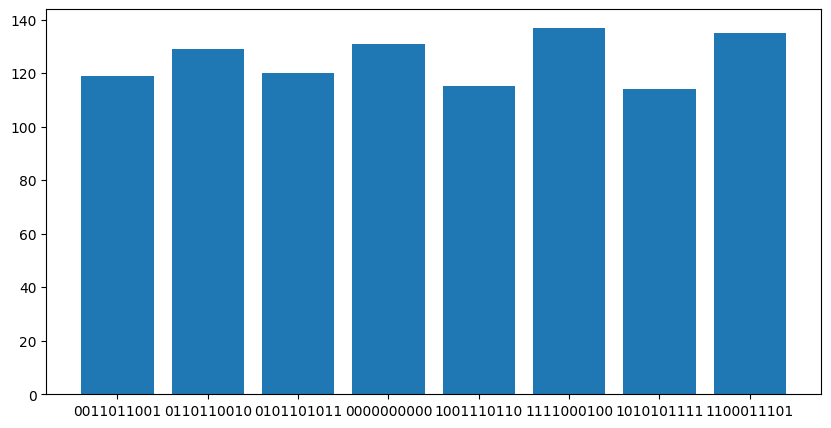

In [28]:
result = job.result().get_counts(qc)
arr = [elem[::-1][:10] for elem in list(result.keys())]
arr_unik_keys = list(set(arr))
arr_values = list(result.values())
arr_unik_values = []
for elem in arr_unik_keys:
    suma = 0
    suma = sum(val for key, val in zip(arr, arr_values) if key == elem)
    arr_unik_values.append(suma)
state_prob = dict(zip(arr_unik_keys, arr_unik_values))
print(state_prob)

plt.figure(figsize=(10,5))
plt.bar(arr_unik_keys, arr_unik_values)
# plt.savefig("10q_logical_1.jpg")

In [13]:
arr_unik_keys

['1100011101',
 '0011011001',
 '0110110010',
 '0101101011',
 '1001110110',
 '1111000100',
 '1010101111',
 '0000000000']

In [ ]:
logical_0 = ['1100011101', '0011011001', '0110110010', '0101101011', '1001110110', '1111000100', '1010101111', '0000000000']
logical_1 = 